In [23]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [20]:
# Observation Definitions
from pynrc.nb_funcs import make_key, obs_wfe, obs_optimize, model_info

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches
from pynrc.nb_funcs import update_yscale, do_plot_contrasts, do_plot_contrasts2
from pynrc.nb_funcs import plot_hdulist, plot_images, plot_images_swlw

In [4]:
from pynrc.nb_funcs import update_yscale


In [5]:
from astropy.table import Table
def make_contrast_tbl(curves):
    
    data = []
    names =[]

    rr = curves[0][0]
    igood = rr>1.5
    data.append(rr[igood])
    names.append('Arcsec')

    for j, vals in enumerate(curves):
        rr, contrast, sen = vals

        data.append(contrast[igood])
        data.append(sen[igood])

        wfe = wfe_list[j]
        names.append('Contr_{:.0f}nm'.format(wfe))
        names.append('Sen_{:.0f}nm'.format(wfe))

    # Modify number formats
    tbl = Table(data, names=names)
    tbl[names[0]].format = '.4f'
    for name in names:
        if  'Cont' in name: fmt = '.3E'
        elif 'Sen' in name: fmt ='.4f'
        else: fmt = tbl[name].format

        tbl[name].format = fmt
        
    return tbl

In [6]:
def update_yscale2(ax, scale_type, ylim=None):
    
    # Some fancy log+linear plotting
    from matplotlib.ticker import FixedLocator, ScalarFormatter, LogFormatterSciNotation
    if scale_type=='symlog':
        ylim = [0,100] if ylim is None else ylim
        ax.set_ylim(ylim)
        yr = ax.get_ylim()
        ax.set_yscale('symlog', linthreshy=10, linscaley=2)
        ax.set_yticks(list(range(0,10)) + [10,100,1000])
        #ax.get_yaxis().set_major_formatter(ScalarFormatter())
        ax.yaxis.set_major_formatter(ScalarFormatter())

        minor_log = list(np.arange(20,100,10)) + list(np.arange(200,1000,100))
        minorLocator = FixedLocator(minor_log)
        ax.yaxis.set_minor_locator(minorLocator)
        ax.set_ylim([0,yr[1]])
    elif scale_type=='log':
        ax.set_yscale('log')
        ylim = [0.1,100] if ylim is None else ylim
        ax.set_ylim(ylim)
        ax.yaxis.set_major_formatter(LogFormatterSciNotation())

## Define Sources and their Reference PSF Stars

In [7]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [8]:
# Argument list:(Name,           dist, age, sptype,  mag)
args_sources = [('AUMic',         9.72,  24,  'M1V',  4.53, bp_k),
                ('HIP17695',     16.80, 150,  'M3V',  6.93, bp_k),
                ('G7-34',        14.59, 150,  'M4V',  8.18, bp_k),
                ('TYC5899',      15.83, 130,  'M3V',  6.89, bp_k),
                ('2MJ0944-1220', 13.13,  50,  'M5V',  7.60, bp_k),
                ('APCol',         8.67,  50,  'M5V',  6.87, bp_k),
                ('FomalhautC',    7.67, 440,  'M4V',  7.21, bp_k),
                ('LP944-20',      6.42, 200,  'M9V',  9.55, bp_k),
                ('2MJ0443+0002', 21.09,  24,  'M9V', 11.22, bp_k)]

ref_sources  = [('TYC5899',      'M3V',  6.9, bp_k),
                ('TYC5899',      'M3V',  6.9, bp_k),
                ('TYC5899',      'M3V',  6.9, bp_k),
                ('HIP17695',     'M3V',  6.9, bp_k),
                ('APCol',        'M5V',  6.9, bp_k),
                ('2MJ0944-1220', 'M5V',  7.6, bp_k),
                ('APCol',        'M5V',  6.9, bp_k),
                ('2MJ0443+0002', 'M9V', 11.2, bp_k),
                ('LP944-20',     'M9V',  9.6, bp_k)]


In [9]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'MDwarfs/'

In [10]:
# List of filters
args_filter = [('F356W', 'MASK430R', 'CIRCLYOT'),
               ('F444W', 'MASK430R', 'CIRCLYOT')]

subsize = 320

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

## AU Mic

In [108]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[0.93760997]


In [109]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[0.92468905]


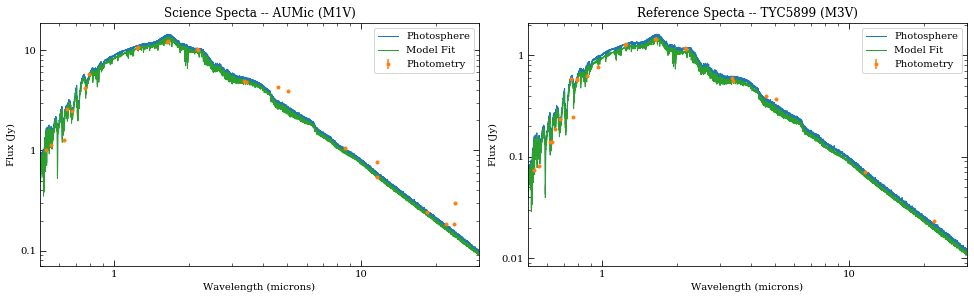

In [110]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

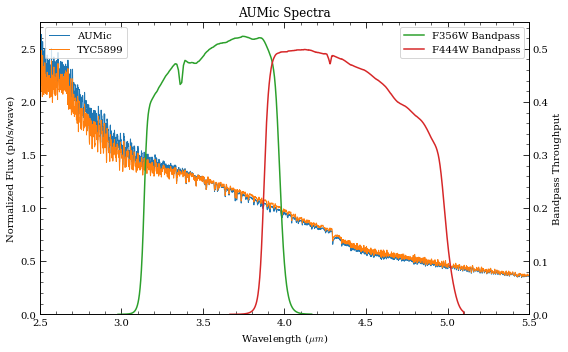

In [111]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
    sp.convert('flam')

    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [112]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [113]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    nint = 17 if 'F444W' in key else 8
    ng = 10
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [114]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F356W_MASK430R_CIRCLYOT
Sci: AUMic
  0 saturated pixel at NGROUP=2; Max Well: 0.19
  3 saturated pixel at NGROUP=10; Max Well: 1.04
  Sat Dist NG=2: 0.00 arcsec
Ref: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.12

F444W_MASK430R_CIRCLYOT
Sci: AUMic
  0 saturated pixel at NGROUP=2; Max Well: 0.09
  0 saturated pixel at NGROUP=10; Max Well: 0.48
  Sat Dist NG=2: 0.00 arcsec
Ref: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06


In [115]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT
F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


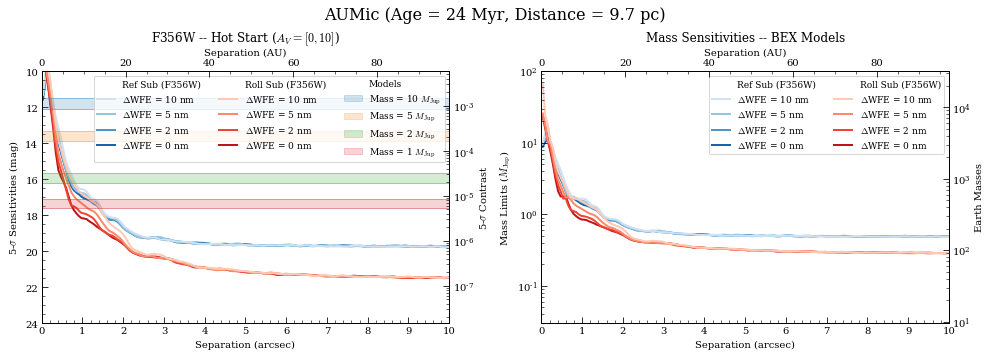

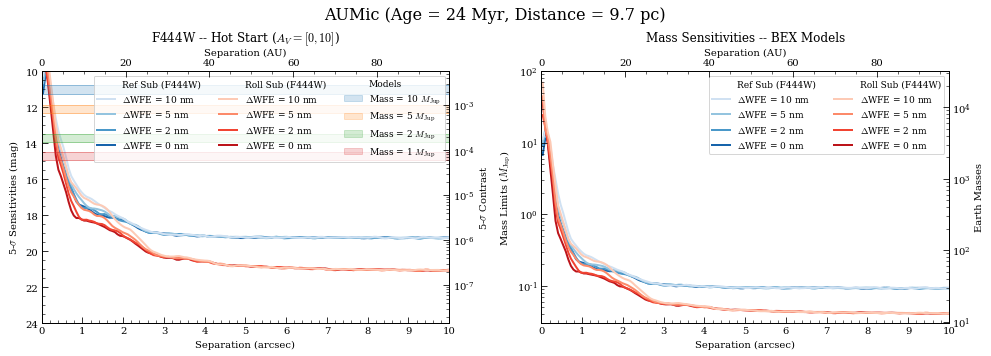

In [117]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
for k in filt_keys:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    fig.savefig(outdir+fname)

In [25]:
# Save curves data
for k in filt_keys:
    prefix = '{}_{}_{:.0f}sig'.format(name_sci.replace(" ", ""), k, nsig)
    
    curves = curves_ref[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_refsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')
    
    curves = curves_roll[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_rollsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')

## HIP 17695

In [26]:
# Fit spectrum to SED photometry
i=1
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[0.95457105]


In [27]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[0.92468905]


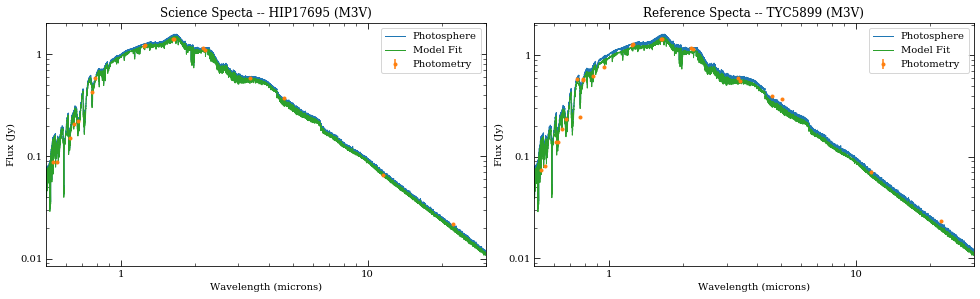

In [28]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

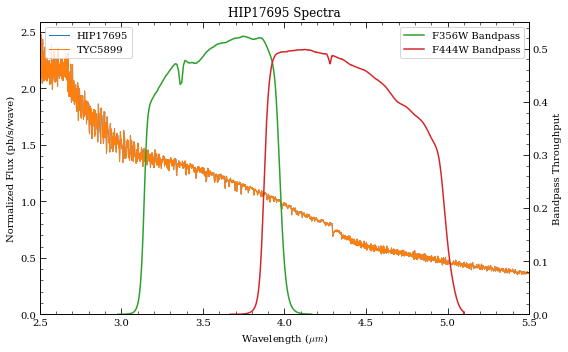

In [29]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
    sp.convert('flam')

    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [30]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [31]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    nint = 17 if 'F444W' in key else 8
    ng = 10
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [32]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F356W_MASK430R_CIRCLYOT
Sci: HIP17695
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.12
  Sat Dist NG=2: 0.00 arcsec
Ref: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.12

F444W_MASK430R_CIRCLYOT
Sci: HIP17695
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06
  Sat Dist NG=2: 0.00 arcsec
Ref: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06


In [33]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT
F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


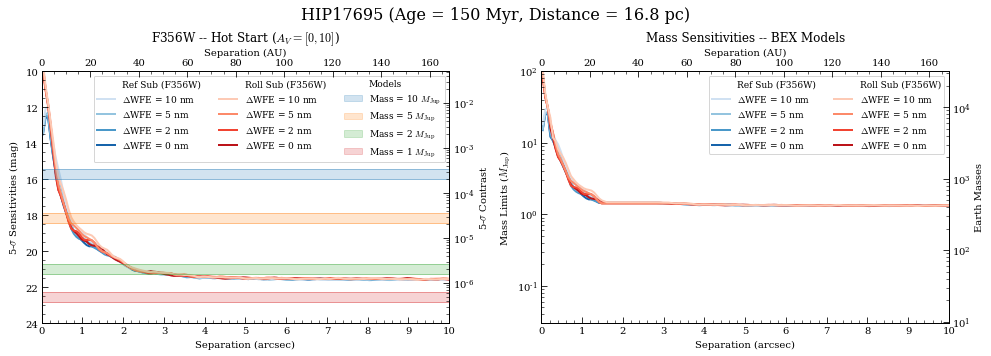

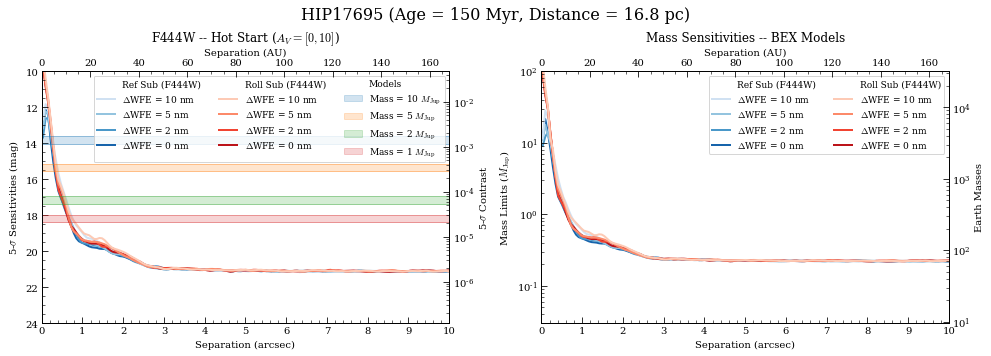

In [36]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
for k in filt_keys:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    fig.savefig(outdir+fname)

In [37]:
# Save curves data
for k in filt_keys:
    prefix = '{}_{}_{:.0f}sig'.format(name_sci.replace(" ", ""), k, nsig)
    
    curves = curves_ref[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_refsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')
    
    curves = curves_roll[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_rollsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')

## G 7-34

In [38]:
# Fit spectrum to SED photometry
i=2
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[0.95148692]


In [39]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[0.92468905]


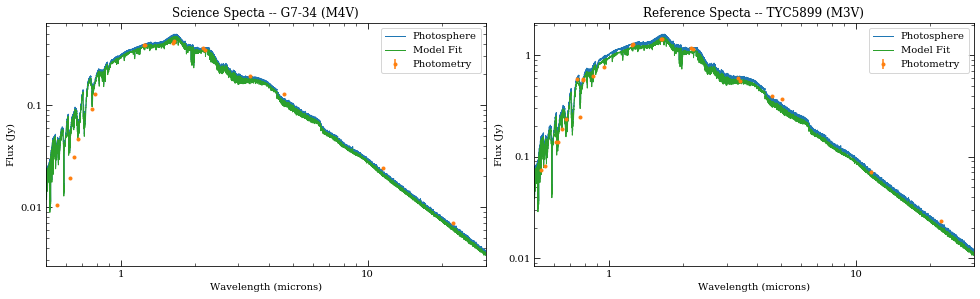

In [40]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

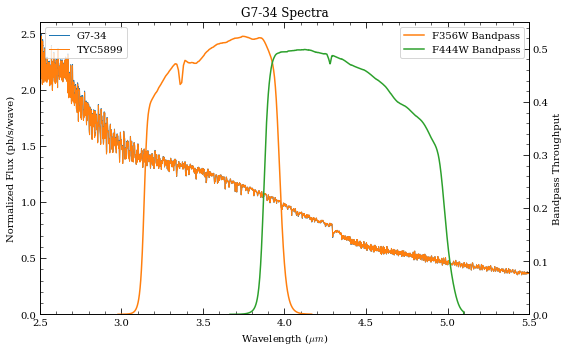

In [41]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
    sp.convert('flam')

    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+1], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [42]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [43]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    nint = 17 if 'F444W' in key else 8
    ng = 10
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [44]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F356W_MASK430R_CIRCLYOT
Sci: G7-34
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.04
  Sat Dist NG=2: 0.00 arcsec
Ref: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.12

F444W_MASK430R_CIRCLYOT
Sci: G7-34
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.02
  Sat Dist NG=2: 0.00 arcsec
Ref: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06


In [45]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT
F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


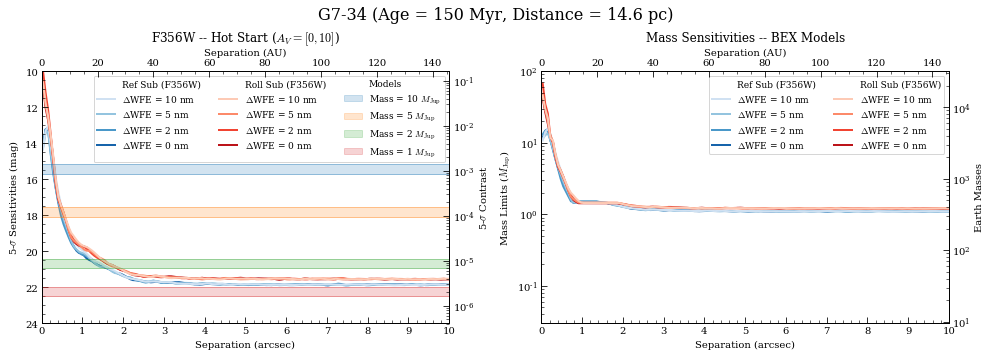

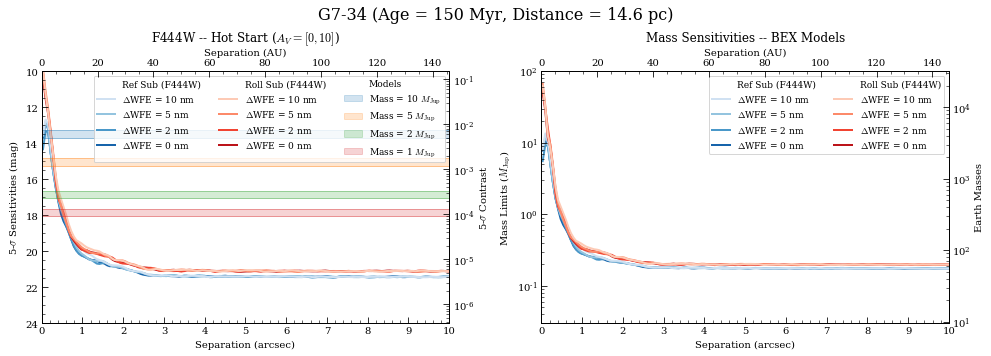

In [46]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
for k in filt_keys:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    fig.savefig(outdir+fname)

In [47]:
# Save curves data
for k in filt_keys:
    prefix = '{}_{}_{:.0f}sig'.format(name_sci.replace(" ", ""), k, nsig)
    
    curves = curves_ref[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_refsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')
    
    curves = curves_roll[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_rollsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')

## TYC5899

In [48]:
# Fit spectrum to SED photometry
i=3
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[0.96251828]


In [49]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True, wlim=[1,5])

# Final reference spectrum
sp_ref = ref.sp_model

[0.92663099]


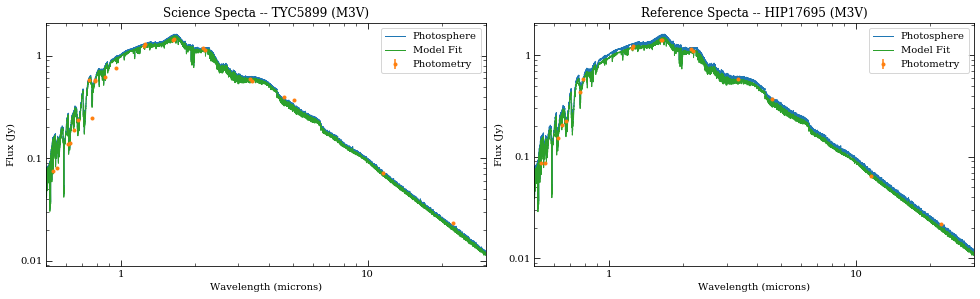

In [50]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

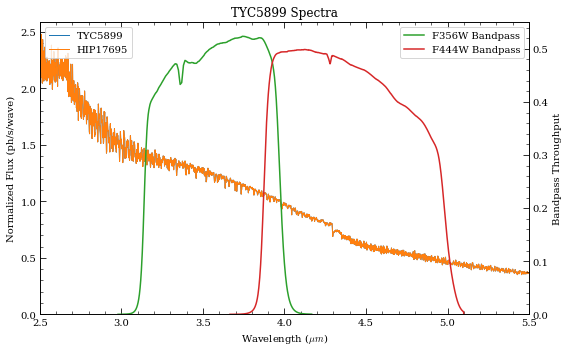

In [51]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
    sp.convert('flam')

    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [52]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [53]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    nint = 17 if 'F444W' in key else 8
    ng = 10
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [54]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F356W_MASK430R_CIRCLYOT
Sci: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.13
  Sat Dist NG=2: 0.00 arcsec
Ref: HIP17695
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.12

F444W_MASK430R_CIRCLYOT
Sci: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06
  Sat Dist NG=2: 0.00 arcsec
Ref: HIP17695
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06


In [55]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT
F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


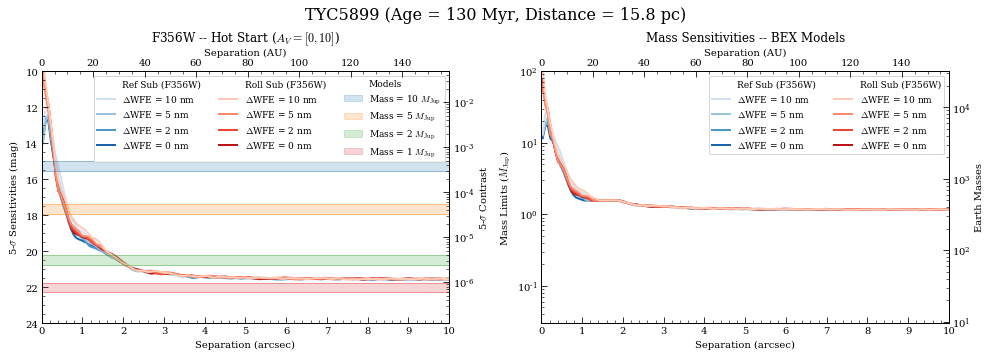

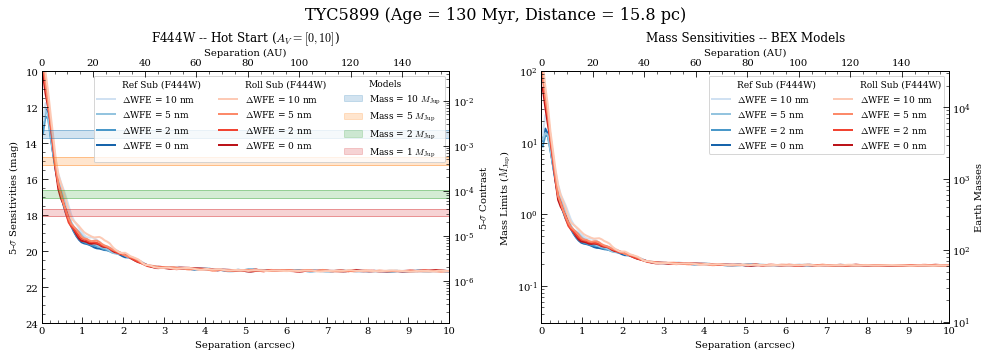

In [56]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
for k in filt_keys:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    fig.savefig(outdir+fname)

In [57]:
# Save curves data
for k in filt_keys:
    prefix = '{}_{}_{:.0f}sig'.format(name_sci.replace(" ", ""), k, nsig)
    
    curves = curves_ref[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_refsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')
    
    curves = curves_roll[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_rollsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')

## 2MJ0944

In [58]:
# Fit spectrum to SED photometry
i=4
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final source spectrum
sp_sci = src.sp_model

[0.98617778]


In [59]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True, wlim=[2,5])

# Final reference spectrum
sp_ref = ref.sp_model

[1.32162046]


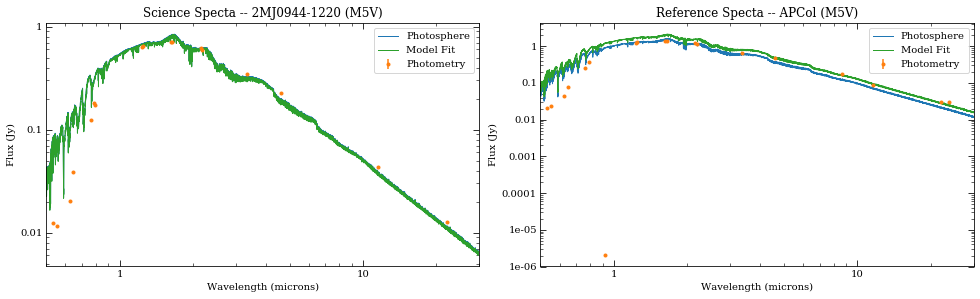

In [60]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

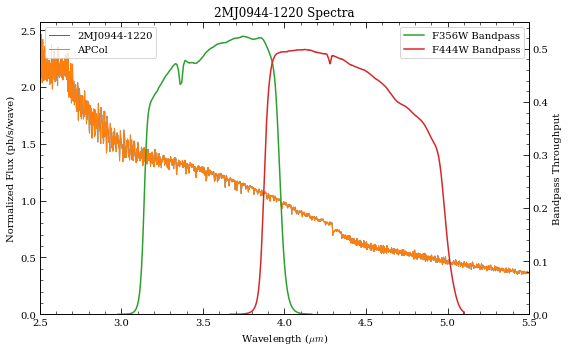

In [61]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
    sp.convert('flam')

    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [62]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [63]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    nint = 17 if 'F444W' in key else 8
    ng = 10
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [64]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F356W_MASK430R_CIRCLYOT
Sci: 2MJ0944-1220
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.07
  Sat Dist NG=2: 0.00 arcsec
Ref: APCol
  0 saturated pixel at NGROUP=2; Max Well: 0.03
  0 saturated pixel at NGROUP=10; Max Well: 0.17

F444W_MASK430R_CIRCLYOT
Sci: 2MJ0944-1220
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.03
  Sat Dist NG=2: 0.00 arcsec
Ref: APCol
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.08


In [65]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT
F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


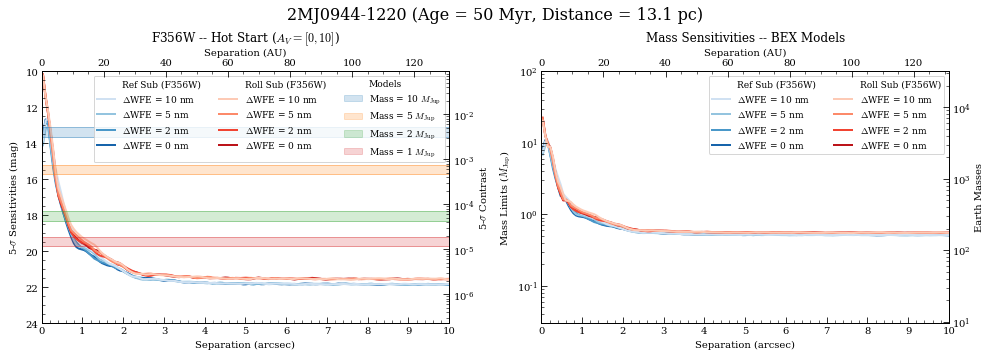

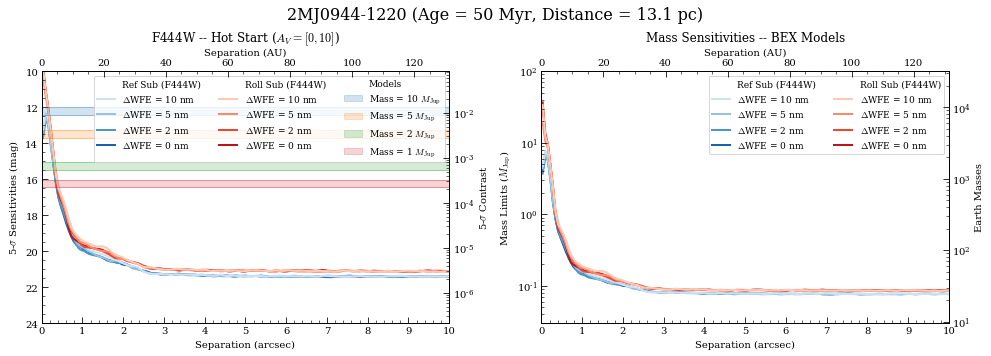

In [66]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
for k in filt_keys:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    fig.savefig(outdir+fname)

In [67]:
# Save curves data
for k in filt_keys:
    prefix = '{}_{}_{:.0f}sig'.format(name_sci.replace(" ", ""), k, nsig)
    
    curves = curves_ref[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_refsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')
    
    curves = curves_roll[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_rollsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')

## AP Col

In [68]:
# Fit spectrum to SED photometry
i=5
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final source spectrum
sp_sci = src.sp_model

[0.9894211]


In [69]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True, wlim=[2,5])

# Final reference spectrum
sp_ref = ref.sp_model

[0.96535837]


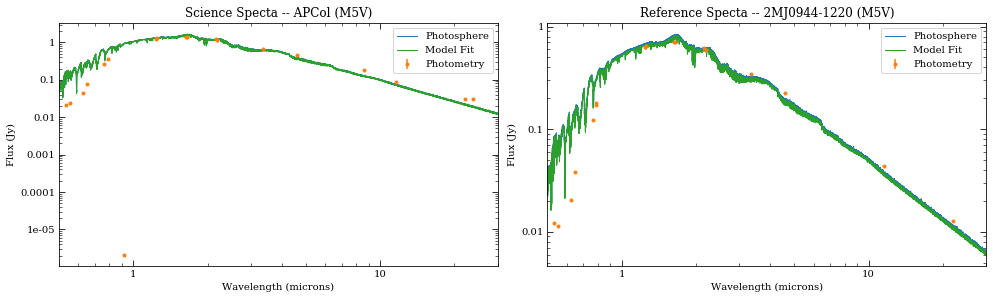

In [70]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

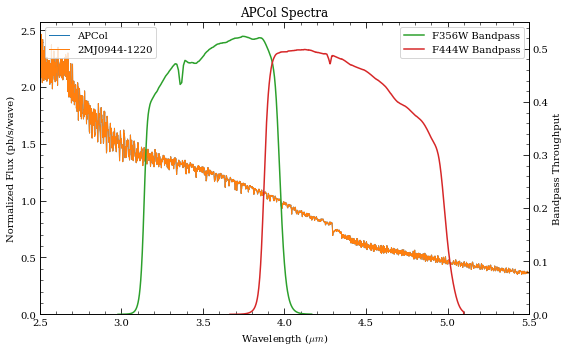

In [71]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
    sp.convert('flam')

    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [72]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [73]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    nint = 17 if 'F444W' in key else 8
    ng = 10
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [74]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F356W_MASK430R_CIRCLYOT
Sci: APCol
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.13
  Sat Dist NG=2: 0.00 arcsec
Ref: 2MJ0944-1220
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.07

F444W_MASK430R_CIRCLYOT
Sci: APCol
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06
  Sat Dist NG=2: 0.00 arcsec
Ref: 2MJ0944-1220
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.03


In [75]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT
F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


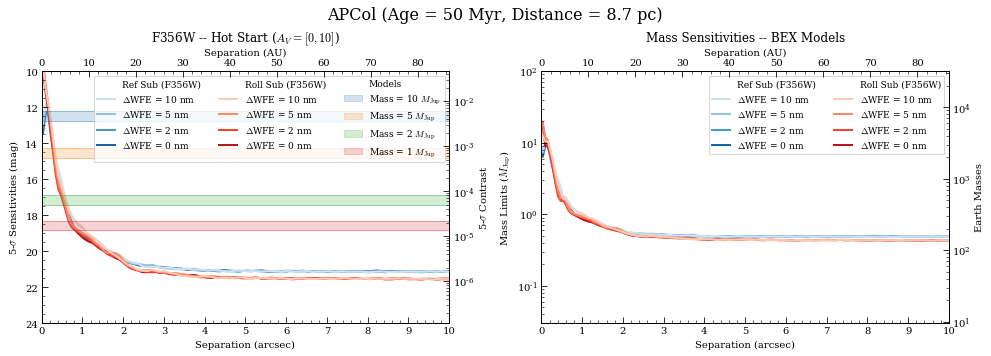

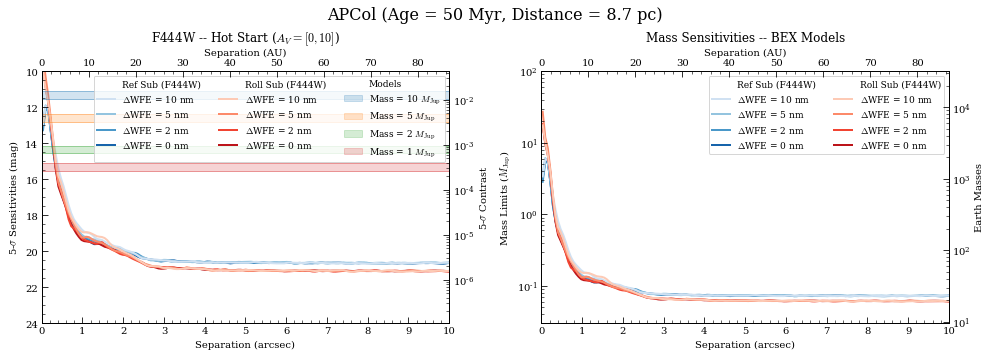

In [76]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
for k in filt_keys:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    fig.savefig(outdir+fname)

In [77]:
# Save curves data
for k in filt_keys:
    prefix = '{}_{}_{:.0f}sig'.format(name_sci.replace(" ", ""), k, nsig)
    
    curves = curves_ref[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_refsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')
    
    curves = curves_roll[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_rollsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')

## Fomalhaut C

In [78]:
# Fit spectrum to SED photometry
i=6
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final source spectrum
sp_sci = src.sp_model

[0.9927219]


In [79]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final reference spectrum
sp_ref = ref.sp_model

[1.01714102]


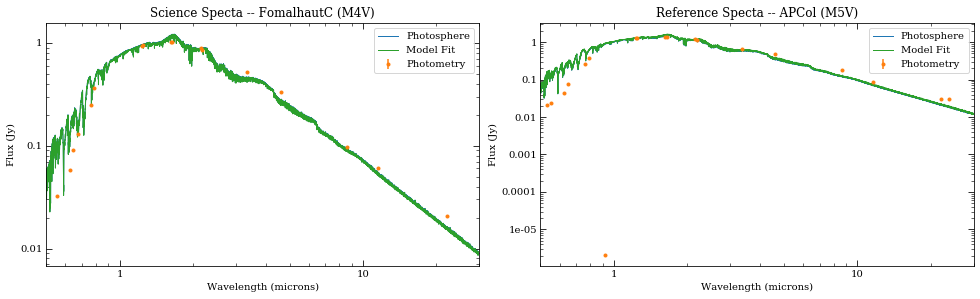

In [80]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

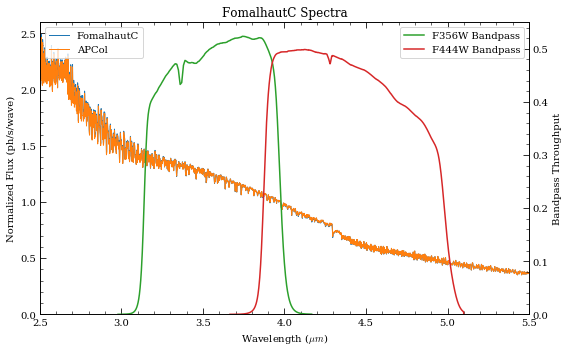

In [81]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
    sp.convert('flam')

    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [82]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [83]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    nint = 17 if 'F444W' in key else 8
    ng = 10
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [84]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F356W_MASK430R_CIRCLYOT
Sci: FomalhautC
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.10
  Sat Dist NG=2: 0.00 arcsec
Ref: APCol
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.13

F444W_MASK430R_CIRCLYOT
Sci: FomalhautC
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.05
  Sat Dist NG=2: 0.00 arcsec
Ref: APCol
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06


In [85]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT
F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


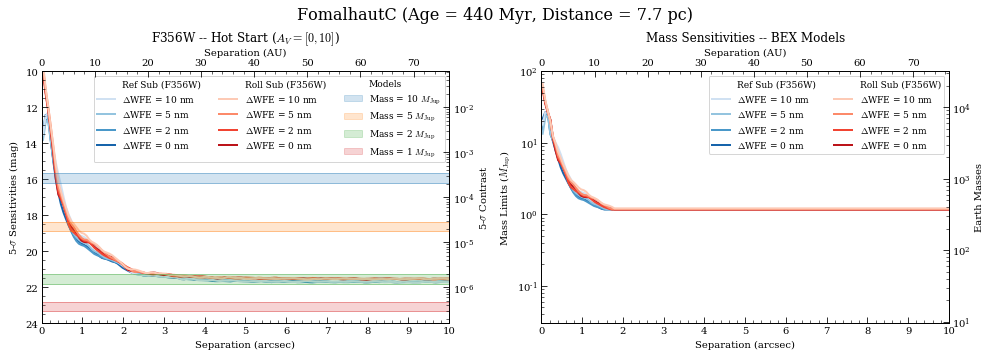

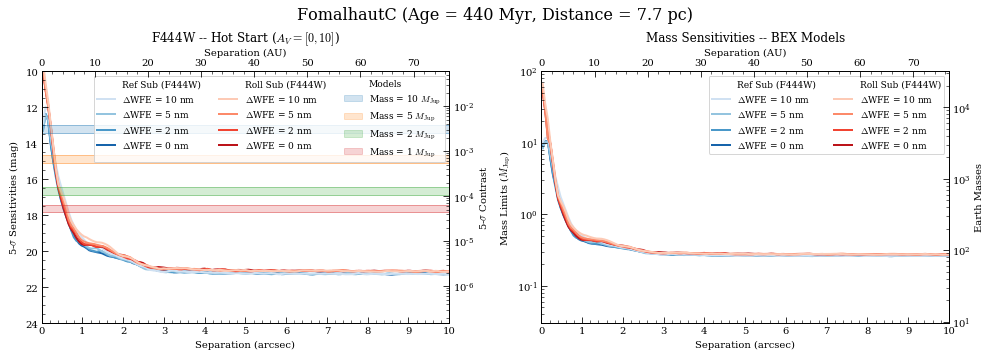

In [86]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
for k in filt_keys:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    fig.savefig(outdir+fname)

In [87]:
# Save curves data
for k in filt_keys:
    prefix = '{}_{}_{:.0f}sig'.format(name_sci.replace(" ", ""), k, nsig)
    
    curves = curves_ref[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_refsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')
    
    curves = curves_roll[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_rollsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')

## LP 944-20

In [88]:
# Fit spectrum to SED photometry
i=7
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final source spectrum
sp_sci = src.sp_model

[1.00332713]


In [89]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final reference spectrum
sp_ref = ref.sp_model

[0.9866139]


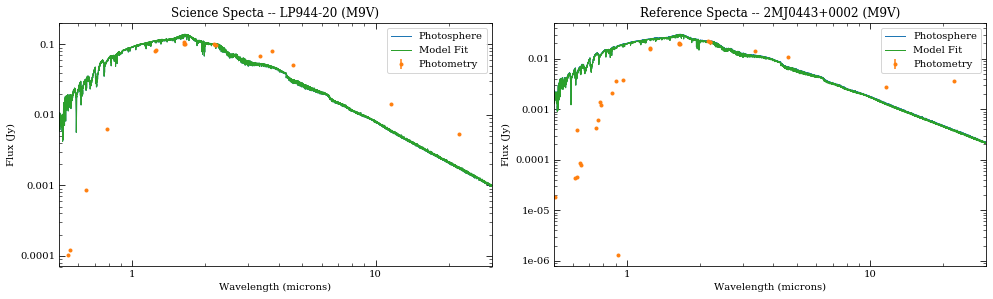

In [90]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

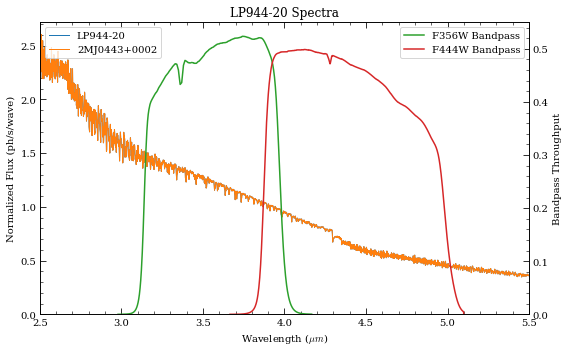

In [91]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
    sp.convert('flam')

    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [92]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [93]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    nint = 17 if 'F444W' in key else 8
    ng = 10
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [94]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F356W_MASK430R_CIRCLYOT
Sci: LP944-20
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.01
  Sat Dist NG=2: 0.00 arcsec
Ref: 2MJ0443+0002
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.00

F444W_MASK430R_CIRCLYOT
Sci: LP944-20
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.01
  Sat Dist NG=2: 0.00 arcsec
Ref: 2MJ0443+0002
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.00


In [95]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT
F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


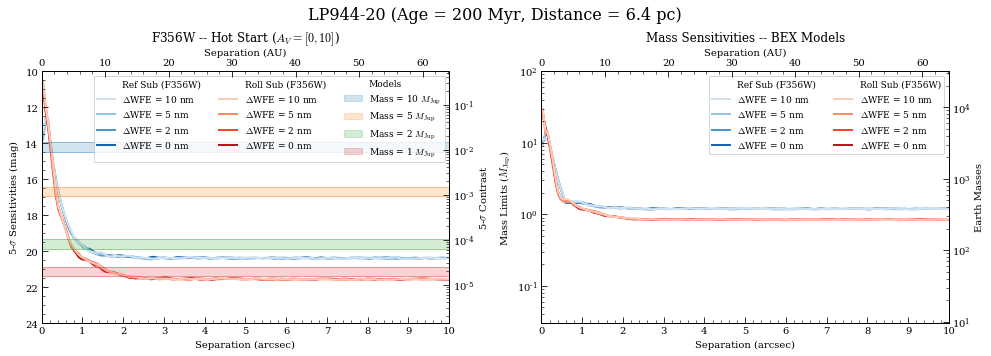

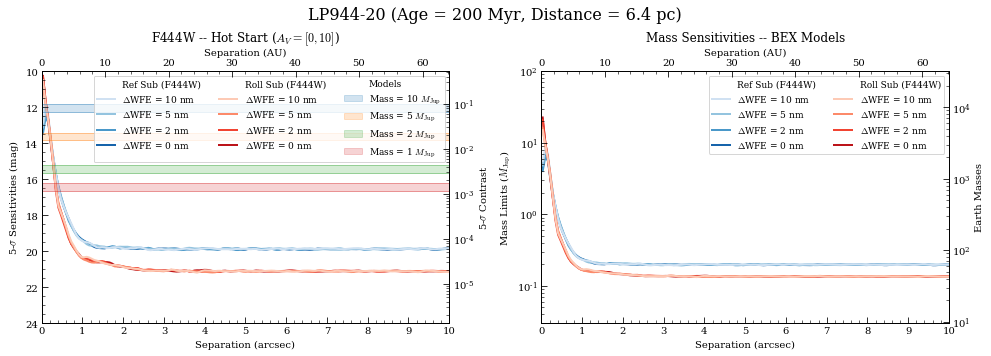

In [96]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
for k in filt_keys:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    fig.savefig(outdir+fname)

In [97]:
# Save curves data
for k in filt_keys:
    prefix = '{}_{}_{:.0f}sig'.format(name_sci.replace(" ", ""), k, nsig)
    
    curves = curves_ref[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_refsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')
    
    curves = curves_roll[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_rollsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')

## 2MJ0443

In [98]:
# Fit spectrum to SED photometry
i=8
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final source spectrum
sp_sci = src.sp_model

[1.00495642]


In [99]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=True, wlim=[2,5])

# Final reference spectrum
sp_ref = ref.sp_model

[1.05061248]


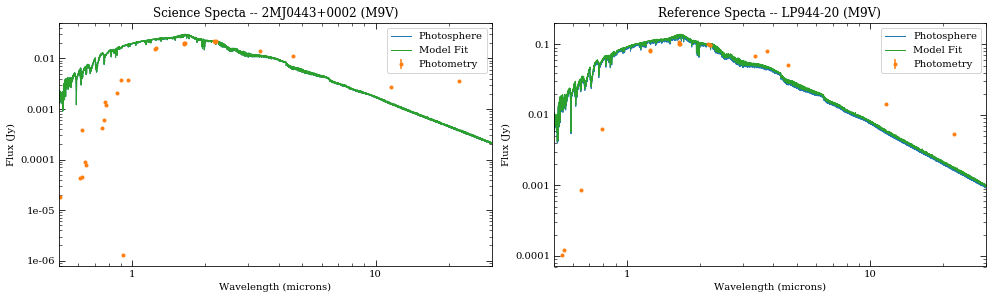

In [100]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

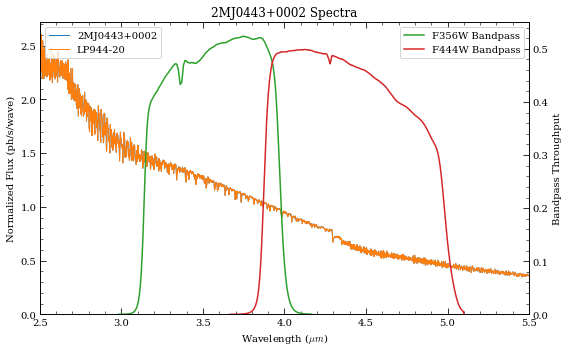

In [101]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
    sp.convert('flam')

    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [102]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


In [103]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    nint = 17 if 'F444W' in key else 8
    ng = 10
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [104]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F356W_MASK430R_CIRCLYOT
Sci: 2MJ0443+0002
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.00
  Sat Dist NG=2: 0.00 arcsec
Ref: LP944-20
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.01

F444W_MASK430R_CIRCLYOT
Sci: 2MJ0443+0002
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.00
  Sat Dist NG=2: 0.00 arcsec
Ref: LP944-20
  0 saturated pixel at NGROUP=2; Max Well: 0.00
  0 saturated pixel at NGROUP=10; Max Well: 0.01


In [105]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT
F356W_MASK430R_CIRCLYOT
F444W_MASK430R_CIRCLYOT


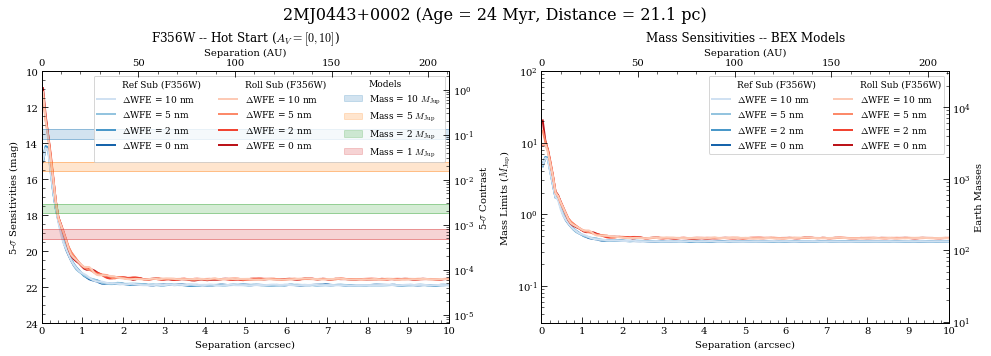

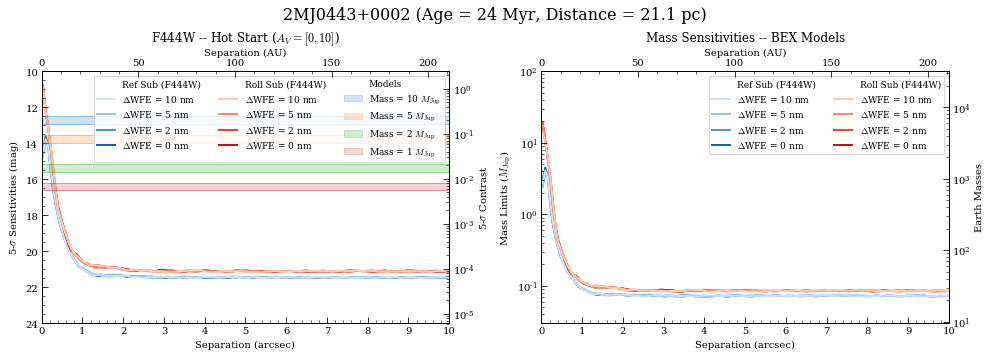

In [106]:
# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
for k in filt_keys:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    fig.savefig(outdir+fname)

In [107]:
# Save curves data
for k in filt_keys:
    prefix = '{}_{}_{:.0f}sig'.format(name_sci.replace(" ", ""), k, nsig)
    
    curves = curves_ref[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_refsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')
    
    curves = curves_roll[k]
    tbl = make_contrast_tbl(curves)
    fname = prefix + '_rollsub.csv'
    tbl.write(outdir+fname, format='ascii.csv')